In [1]:
# Hemorrhage detection in covid samples

In [2]:
""" COVID"""

# Libraries
from skimage import io
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
%matplotlib inline
from PIL import Image

import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, History

from tensorflow.keras import backend as K

import glob 
import cv2
from scipy import misc
import sys

from zipfile import ZipFile 

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

import imageio
import random

import datetime
import json
from tensorflow.keras.models import model_from_json

import imgaug as ia
from imgaug import augmenters as iaa
import imageio

import pandas as pd
import six
import csv


from Unet import *
from COVID_Tissue_Code import *
from RGB_OneHot import rgb_to_onehot, onehot_to_rgb
from Brightness_Augmentation import brightness_augmentation
 

ia.seed(1)

Using TensorFlow backend.


In [3]:
print(tf.__version__)

2.3.1


In [4]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.compat.v1.Session(config=config)

## Model implementation

In [5]:
"""Input directory"""

Train_path = "Train_hemorrhage"
Val_path = "Validation_hemorrhage"

In [6]:
"""Output directory"""

path0 = os.path.dirname(os.path.realpath("20_COVID_DL"))
print(path0)

history_path = path0 + '/History_data_covid'
weights_path = path0 + '/Weights_data_covid'

/home/teodora/Teodora/20_COVID_DL_surf


In [7]:
"""Set experiment time""" 

current_date = datetime.datetime.today().strftime('%Y-%m-%d')+"_"

In [8]:
"""Set experiment order"""

Exp = 'A'

In [9]:
"""Model parameters (inputs)"""

n_classes = 3
patch_size = 512 #both height and width 

batch_size = 8
n_epoch = 200

learning_rate = 0.001
patience = 0

In [10]:
class_weights=None

In [11]:
# """U-net implementation"""

model = Unet(n_classes = n_classes, class_weights = class_weights)
model.summary()

(None, 512, 512, 32)
(None, 256, 256, 64)
(None, 128, 128, 128)
(None, 64, 64, 256)
(None, 32, 32, 512)
(None, 512, 512, 32)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 32) 0       

## Train data 

In [12]:
train_images = tf.keras.preprocessing.image_dataset_from_directory(
    directory = Train_path+"/Patches",
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(patch_size, patch_size),
    shuffle=True,
    seed=2
)

train_masks = tf.keras.preprocessing.image_dataset_from_directory(
    directory = Train_path+"/Masks",
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(patch_size, patch_size),
    shuffle=True,
    seed=2
)

val_images = tf.keras.preprocessing.image_dataset_from_directory(
    directory = Val_path+"/Patches",
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(patch_size, patch_size),
    shuffle=True,
    seed=2
)

val_masks = tf.keras.preprocessing.image_dataset_from_directory(
    directory = Val_path+"/Masks",
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(patch_size, patch_size),
    shuffle=True,
    seed=2
)

Found 5787 files belonging to 1 classes.
Found 5787 files belonging to 1 classes.
Found 1535 files belonging to 1 classes.
Found 1536 files belonging to 1 classes.


In [13]:
from tensorflow.keras.preprocessing.image import DirectoryIterator, ImageDataGenerator

SEED=2
SHUFFLE=True
augmentation_arguments_images= dict(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rotation_range=360.0,
    brightness_range=None,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255.,
    fill_mode="constant",
    cval=255.0,
    preprocessing_function=None)

augmentation_arguments_masks= dict(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rotation_range=360.0,
    brightness_range=None,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None,
    fill_mode="constant",
    cval=255.0,
    preprocessing_function=rgb_to_onehot)

image_datagen = ImageDataGenerator(**augmentation_arguments_images).flow_from_directory(directory = Train_path+"/Patches", batch_size= batch_size, target_size =(patch_size,patch_size), color_mode="rgb", class_mode=None, seed=SEED, shuffle=SHUFFLE)
mask_datagen = ImageDataGenerator(**augmentation_arguments_masks).flow_from_directory(directory = Train_path+"/Masks", batch_size= batch_size, target_size =(patch_size,patch_size), color_mode="rgb", class_mode=None, seed=SEED, shuffle=SHUFFLE)

train_generator= zip(image_datagen, mask_datagen)

Found 5787 images belonging to 1 classes.
Found 5787 images belonging to 1 classes.


In [14]:
# (a,b)= next(train_generator)

# (f, [ax0,ax1]) = plt.subplots(1, 2, figsize = (12, 6))
# print(a[0].__getitem__(5))
# ax0.imshow(a[0].__getitem__(5))
# print(b[0].__getitem__(5))
# ax1.imshow(onehot_to_rgb(b[0].__getitem__(5)))

# # # plt.imsave("test.png")

In [15]:
"""Count training data"""
n_train_samples = len([name for name in os.listdir(Train_path + '/Patches/Group1/')])
print (n_train_samples)

5787


## Validation data

In [16]:
# from tensorflow.keras.preprocessing.image import DirectoryIterator, ImageDataGenerator

SEED=2
SHUFFLE=False

augmentation_arguments_images_val= dict(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rotation_range=None,
    brightness_range=None,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1./255.,
    fill_mode="constant",
    cval=255.0,
    preprocessing_function=None)

augmentation_arguments_masks_val= dict(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rotation_range=None,
    brightness_range=None,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    fill_mode="constant",
    cval=255.0,
    preprocessing_function=rgb_to_onehot
                                      )

image_datagen_val = ImageDataGenerator(**augmentation_arguments_images_val).flow_from_directory(directory = Val_path+"/Patches", batch_size= batch_size, target_size =(patch_size,patch_size), color_mode="rgb",class_mode=None, seed=SEED, shuffle=SHUFFLE)
mask_datagen_val = ImageDataGenerator(**augmentation_arguments_masks_val).flow_from_directory(directory = Val_path+"/Masks", batch_size= batch_size, target_size =(patch_size,patch_size), color_mode="rgb",class_mode=None, seed=SEED, shuffle=SHUFFLE)

val_generator = zip(image_datagen_val, mask_datagen_val)


Found 1535 images belonging to 1 classes.
Found 1536 images belonging to 1 classes.


In [17]:
# (a,b)= next(val_generator)

# (f, [ax0,ax1]) = plt.subplots(1, 2, figsize = (12, 6))
# ax0.imshow(a[0].__getitem__(5))
# # print(b[0].__getitem__(5))
# ax1.imshow((b[0].__getitem__(5)))

In [18]:
"""Count validation data"""
n_validation_samples  = len([name for name in os.listdir(Val_path + '/Patches/Group1/')])
print (n_validation_samples)

1535


## Weight, history and model run

In [19]:
"""Output weights setup"""

if not os.path.exists(weights_path):
        os.makedirs(weights_path)

weights_file = weights_path + '/Weights_H_' + current_date + Exp +'_{epoch:02d}.h5'

if not os.path.exists(weights_file):
    with open(weights_file, 'w'): pass

In [20]:
"""Train model and parameter setup"""
import math
n_epoch=500
model_checkpoint = ModelCheckpoint(weights_file, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')

#earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, verbose = 1, mode = 'auto')
#history = keras.callbacks.History()

history = model.fit(train_generator,
                    steps_per_epoch = math.floor(n_train_samples/batch_size),
                    epochs = n_epoch,
                    validation_data = val_generator,
                    shuffle = True,
                    callbacks = [model_checkpoint],
                    validation_steps = math.floor(n_validation_samples/batch_size),
                    #use_multiprocessing=True,
                    #workers=2
                   )

Epoch 1/500
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/teodora/anaconda3/envs/DL_img_0/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-f6a5384df51d>", line 15, in <module>
    validation_steps = math.floor(n_validation_samples/batch_size),
  File "/home/teodora/anaconda3/envs/DL_img_0/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "/home/teodora/anaconda3/envs/DL_img_0/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py", line 1098, in fit
    tmp_logs = train_function(iterator)
  File "/home/teodora/anaconda3/envs/DL_img_0/lib/python3.7/site-packages/tensorflow/python/eager/def_function.py", line 780, in __call__
    result = self._call(*args, **kwds)
  File "/home/teodora/anaconda3/envs/DL_img_0/lib/python3.7/site-packages/tensorflow/python/eager/def_fun

TypeError: object of type 'NoneType' has no len()

# """Save weights"""

model.save_weights(weights_file)

print("Weights saved")

In [28]:
"""Save history"""

# if not os.path.exists(history_path):
#         os.makedirs(history_path)

# history_file = history_path + '/History_data_' + current_date + Exp +'.json'

# if not os.path.exists(history_file):
#     with open(history_file, 'w'): pass

# with open (history_file,'w') as file:
#     json.dump((history.history), file)
    
# print("History saved")  
# print(history.history.keys())

'Save history'

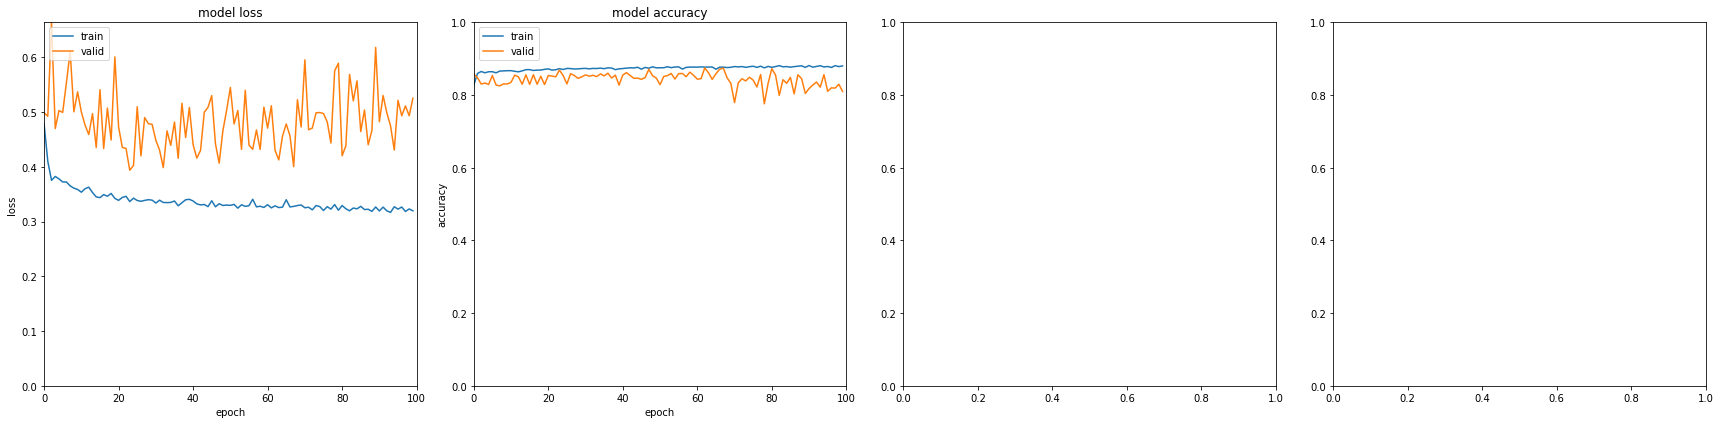

In [29]:
"""Output training and validation performance evaluation"""



(f, [ax0, ax1]) = plt.subplots(1, 2, figsize = (24, 6))

ax0.plot(history.history['loss'])
ax0.plot(history.history['val_loss'])
ax0.set_title('model loss')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend(['train', 'valid'], loc = 'upper left')
ax0.axis([0, n_epoch, 0, max(history.history['val_loss'])])

ax1.plot((history.history['accuracy']))
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'valid'], loc = 'upper left')
ax1.axis([0, n_epoch, 0, 1])

# ax2.plot(history.history['recall'])
# ax2.plot(history.history['val_recall'])
# ax2.set_title('model recall')
# ax2.set_ylabel('recall')
# ax2.set_xlabel('epoch')
# ax2.legend(['train', 'valid'], loc = 'upper left')
# ax2.axis([0, n_epoch, 0, 1])

# ax3.plot(history.history['precision'])
# ax3.plot(history.history['val_precision'])
# ax3.set_title('model precision')
# ax3.set_ylabel('precision')
# ax3.set_xlabel('epoch')
# ax3.legend(['train', 'valid'], loc = 'upper left')
# ax3.axis([0, n_epoch, 0, 1])

plt.tight_layout()
plt.show()